In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'
import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Attetion layer
class FeedForwardAttention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(FeedForwardAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def call(self, x):

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.softmax(eij)

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [3]:
embed_file = os.path.join('.', 'Glove', 'glove.6B.100d.txt')
train_file = os.path.join('.', 'train.csv')
test_file = os.path.join('.', 'test.csv')

In [4]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [5]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [6]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [7]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embed_file, encoding='utf-8'))

In [8]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.004451992, 0.4081574)

In [9]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [10]:
K.clear_session()

In [11]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = Dropout(0.2)(x)
x = FeedForwardAttention(step_dim=maxlen)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.9, random_state=3)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
cp = ModelCheckpoint(filepath="my_model5.h5", save_best_only=True)
es = EarlyStopping(patience=1)
rp = ReduceLROnPlateau(patience = 0)
hist = model.fit(X_tra, y_tra, batch_size = 512, epochs=10, validation_data=(X_val, y_val), callbacks=[cp, es, rp, RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 681s 5ms/step - loss: 0.1087 - acc: 0.9679 - val_loss: 0.0643 - val_acc: 0.9770

 ROC-AUC - epoch: 1 - score: 0.961178 

Epoch 2/10
143613/143613 [==============================] - 902s 6ms/step - loss: 0.0574 - acc: 0.9795 - val_loss: 0.0535 - val_acc: 0.9804

 ROC-AUC - epoch: 2 - score: 0.968452 

Epoch 3/10
143613/143613 [==============================] - 919s 6ms/step - loss: 0.0507 - acc: 0.9813 - val_loss: 0.0513 - val_acc: 0.9812

 ROC-AUC - epoch: 3 - score: 0.969391 

Epoch 4/10
143613/143613 [==============================] - 920s 6ms/step - loss: 0.0470 - acc: 0.9826 - val_loss: 0.0493 - val_acc: 0.9817

 ROC-AUC - epoch: 4 - score: 0.972123 

Epoch 5/10
143613/143613 [==============================] - 926s 6ms/step - loss: 0.0442 - acc: 0.9833 - val_loss: 0.0486 - val_acc: 0.9819

 ROC-AUC - epoch: 5 - score: 0.973081 

Epoch 6/10
143613/143613 [==================

{'val_loss': [0.06426389404654369, 0.05352948734688272, 0.051265129831884866, 0.0493177429414928, 0.048643829877371474, 0.04918538841583149], 'val_acc': [0.976960385408986, 0.9804382635875071, 0.9812006761905528, 0.9817228905089981, 0.9819108830431766, 0.9815244519900284], 'loss': [0.10870700585041257, 0.05741597267149294, 0.05072385671014452, 0.047037739956739315, 0.04415204613398758, 0.04188413960427295], 'acc': [0.9678917460552221, 0.9794540749654169, 0.9813445779625528, 0.9825758936536118, 0.9833337222777022, 0.9838489938396375], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


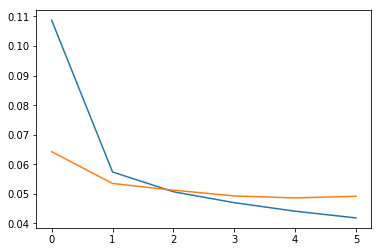

In [14]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])
#plt.plot (hist.history['RocAus'])

In [17]:
y_pred = model.predict(X_te, batch_size=1024)
submission = pd.read_csv('./sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission5.csv', index=False)